In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%load_ext tensorboard

In [1]:
class Block(tf.keras.Model):
    
    def __init__(self, forecast_horizon, backcast_horizon, custom_theta=None):
        super(Block, self).__init__()
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(backcast_horizon, activation='relu', input_shape=(backcast_horizon,)),
            tf.keras.layers.Dense(backcast_horizon, activation='relu'),
            tf.keras.layers.Dense(backcast_horizon, activation='relu'),
            tf.keras.layers.Dense(backcast_horizon, activation='relu')])
        self.v_b = tf.keras.layers.Dense(backcast_horizon)
        self.v_f = tf.keras.layers.Dense(forecast_horizon)
        if custom_theta:
            self.l_b = custom_theta
            self.l_f = custom_theta
        else:
            self.l_b = tf.keras.layers.Dense(backcast_horizon)
            self.l_f = tf.keras.layers.Dense(forecast_horizon)
    
    def call(self, x):
        out = self.fc(x)
        out_b = self.v_b(self.l_b(out))
        out_f = self.v_f(self.l_f(out))
        return out_b, out_f
    
    
class Stack(tf.keras.Model):
    
    def __init__(self, forecast_horizon, backcast_horizon, n_blocks, custom_theta=None):
        super(Stack, self).__init__()
        self.n_blocks = n_blocks
        self.blocks = []
        for k in range(n_blocks):
            self.blocks.append(Block(forecast_horizon, backcast_horizon, custom_theta=custom_theta))

    
    def call(self, x):
        residual = x
        back, fore = self.blocks[0](x)
        forecasts = [fore]
        for k in range(1, self.n_blocks):
            new_residual = back
            back, fore = self.blocks[k](residual - back)
            residual = new_residual
            forecasts.append(fore)
        return residual - back, tf.math.add_n(forecasts)
    
class NBeats(tf.keras.Model):
    
    def __init__(self, forecast_horizon, backcast_horizon, n_blocks, n_stacks, custom_theta=None):
        super(NBeats, self).__init__()
        self.n_stacks = n_stacks
        self.stacks = []
        for k in range(self.n_stacks):
            self.stacks.append(Stack(forecast_horizon, backcast_horizon, n_blocks, custom_theta=custom_theta))

    
    def call(self, x):
        outputs = []
        for k in range(self.n_stacks):
            x, out = self.stacks[k](x)
            outputs.append(out)
        return tf.math.add_n(outputs)
    
class NBeatsInjection(tf.keras.Model):
    
    def __init__(self, forecast_horizon, backcast_horizon, n_blocks, n_stacks):
        super(NBeats, self).__init__()
        self.injector = tf.keras.Sequential([tf.keras.layers.Dense(100, 'relu'),
                                             tf.keras.layers.Dense(100, 'relu'),
                                             tf.keras.layers.Dense(100, 'relu'),
                                             tf.keras.layers.Dense()])
        self.n_stacks = n_stacks
        self.stacks = []
        for k in range(self.n_stacks):
            self.stacks.append(Stack(forecast_horizon, backcast_horizon, n_blocks, custom_theta=))

    
    def call(self, x):
        outputs = []
        for k in range(self.n_stacks):
            x, out = self.stacks[k](x)
            outputs.append(out)
        return tf.math.add_n(outputs)


NameError: name 'tf' is not defined

In [3]:
x_cols = ['StringencyIndexForDisplay',
          'StringencyIndexForDisplay_shift3', 'StringencyIndexForDisplay_shift6',
          'StringencyIndexForDisplay_shift9', 'StringencyIndexForDisplay_shift12',
          'ConfirmedCases_shift5', 'ConfirmedCases_shift6',
          'ConfirmedCases_shift7', 'ConfirmedCases_shift8',
          'ConfirmedCases_shift9', 'SH.MED.BEDS.ZS', 'SH.MED.PHYS.ZS',
          'SH.MED.NUMW.P3', 'SH.UHC.SRVS.CV.XD', 'SH.XPD.CHEX.GD.ZS',
          'SH.XPD.CHEX.PC.CD', 'SH.XPD.CHEX.PP.CD', 'SH.XPD.OOPC.CH.ZS',
          'SH.XPD.OOPC.PC.CD', 'SH.XPD.OOPC.PP.CD', 'SH.STA.DIAB.ZS',
          'SP.DYN.LE00.FE.IN', 'SP.DYN.LE00.IN', 'SP.DYN.LE00.MA.IN',
          'SP.DYN.AMRT.FE', 'SP.DYN.AMRT.MA', 'SH.DYN.NCOM.ZS',
          'SH.DYN.NCOM.FE.ZS', 'SH.DYN.NCOM.MA.ZS', 'SH.DTH.COMM.ZS',
          'SH.DTH.INJR.ZS', 'SH.DTH.NCOM.ZS', 'SH.H2O.BASW.ZS', 'SH.STA.BASS.ZS',
          'SP.POP.80UP.FE.5Y', 'SP.POP.80UP.MA.5Y', 'SP.POP.65UP.FE.ZS',
          'SP.POP.65UP.MA.ZS', 'SP.POP.65UP.TO.ZS', 'SP.POP.0014.FE.ZS',
          'SP.POP.0014.MA.ZS', 'SP.POP.0014.TO.ZS', 'SP.POP.1564.FE.ZS',
          'SP.POP.1564.MA.ZS', 'SP.POP.1564.TO.ZS', 'SP.POP.TOTL', 'HDI']

y_cols = ['ConfirmedCases', 'ConfirmedCases_shift1', 'ConfirmedCases_shift2',
          'ConfirmedCases_shift3', 'ConfirmedCases_shift4',]

train = pd.read_csv('train.csv')
train_x, train_y = train[x_cols].values, train[y_cols].values
test = pd.read_csv('test.csv')
test_x, test_y = test[x_cols].values, test[y_cols].values

nbeats_args = {'n_stacks': 2,
               'n_blocks': 3,
               'forecast_horizon': len(y_cols),
               'backcast_horizon': len(x_cols)}

log_dir = "logs/fit/" + pd.Timestamp.now().strftime("%Y%m%d-%H%M%S")

In [4]:
tf.keras.backend.clear_session()
model = NBeats(**nbeats_args)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer, loss=loss)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_x, train_y,
          validation_data=(test_x, test_y),
          epochs=200, batch_size=8, 
          callbacks=[tensorboard_callback])
# model.call(train_x[0][np.newaxis, :])

Epoch 1/200
532/532 [==============================] - 3s 5ms/step - loss: 26070.7441 - val_loss: 14.7463
Epoch 2/200
532/532 [==============================] - 3s 5ms/step - loss: 5243.4067 - val_loss: 8.8641
Epoch 3/200
532/532 [==============================] - 4s 7ms/step - loss: 4515.8081 - val_loss: 8.2335
Epoch 4/200
532/532 [==============================] - 3s 6ms/step - loss: 1947.4594 - val_loss: 4.8938
Epoch 5/200
532/532 [==============================] - 3s 6ms/step - loss: 1588.1902 - val_loss: 11.6802
Epoch 6/200
532/532 [==============================] - 4s 7ms/step - loss: 4418.8262 - val_loss: 7.1384
Epoch 7/200
532/532 [==============================] - 4s 8ms/step - loss: 939.0951 - val_loss: 3.5138
Epoch 8/200
532/532 [==============================] - 5s 9ms/step - loss: 1219.4891 - val_loss: 27.0338
Epoch 9/200
532/532 [==============================] - 3s 6ms/step - loss: 1746.5504 - val_loss: 8.4573
Epoch 10/200
532/532 [==============================] - 4s 8m

532/532 [==============================] - 3s 5ms/step - loss: 522.4210 - val_loss: 3.7458
Epoch 151/200
532/532 [==============================] - 3s 5ms/step - loss: 323.3934 - val_loss: 3.2977
Epoch 152/200
532/532 [==============================] - 4s 7ms/step - loss: 320.3834 - val_loss: 3.3205
Epoch 153/200
532/532 [==============================] - 4s 8ms/step - loss: 314.0405 - val_loss: 4.0201
Epoch 154/200
532/532 [==============================] - 3s 6ms/step - loss: 528.5360 - val_loss: 6.8362
Epoch 155/200
532/532 [==============================] - 3s 5ms/step - loss: 258.4154 - val_loss: 3.6830
Epoch 156/200
532/532 [==============================] - 3s 5ms/step - loss: 316.2858 - val_loss: 3.5950
Epoch 157/200
532/532 [==============================] - 3s 5ms/step - loss: 219.5146 - val_loss: 4.2534
Epoch 158/200
532/532 [==============================] - 3s 5ms/step - loss: 244.7884 - val_loss: 6.2053
Epoch 159/200
532/532 [==============================] - 3s 5ms/step 

In [5]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 21844), started 5 days, 16:48:32 ago. (Use '!kill 21844' to kill it.)

In [6]:
!taskkill /F /PID 21844

ERROR: The process "21844" not found.


In [7]:
import pkg_resources

for entry_point in pkg_resources.iter_entry_points('tensorboard_plugins'):
    print(entry_point.dist)

tensorboard 2.2.1
tensorboard-plugin-wit 1.6.0.post2


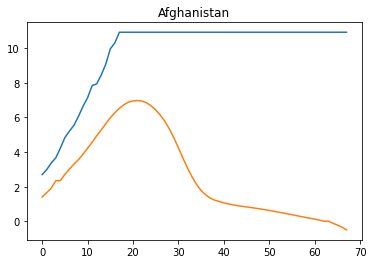

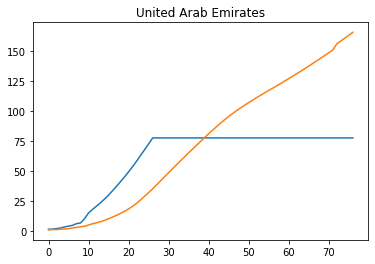

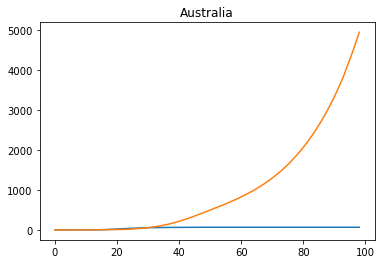

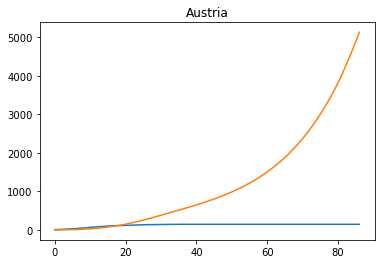

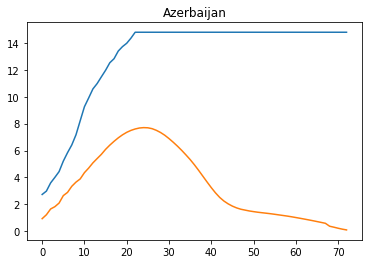

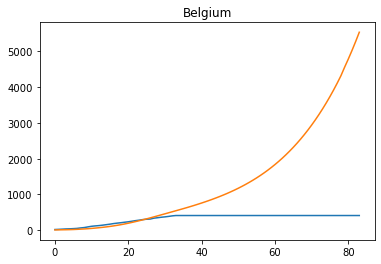

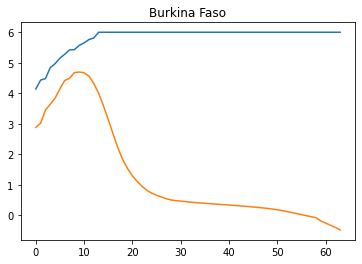

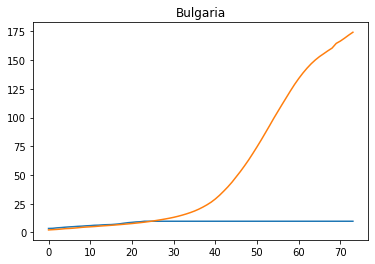

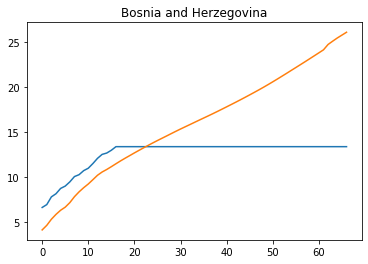

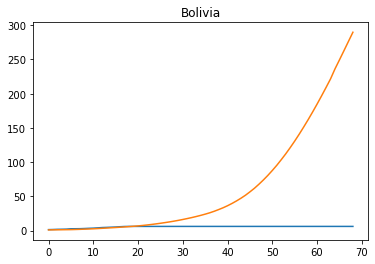

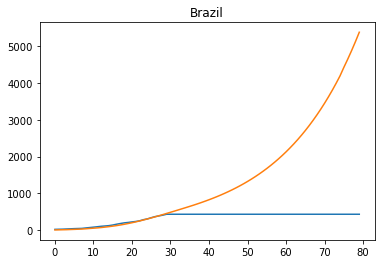

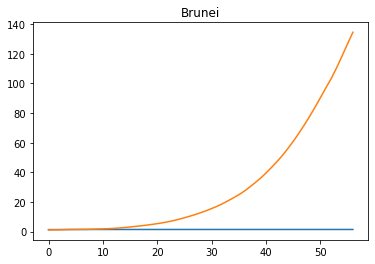

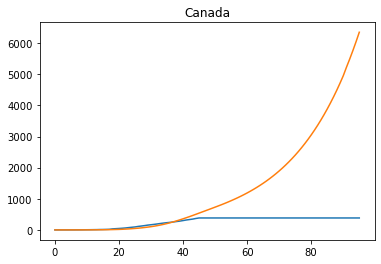

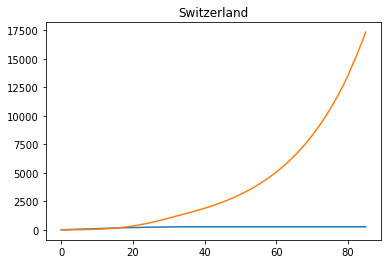

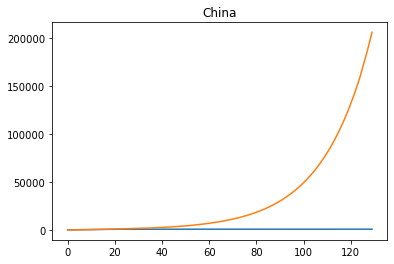

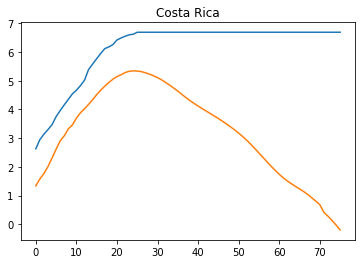

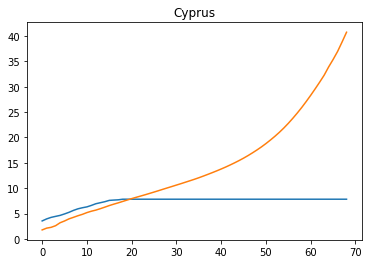

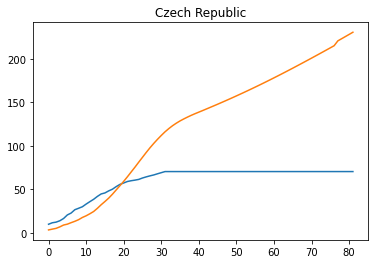

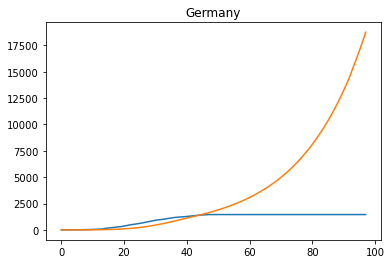

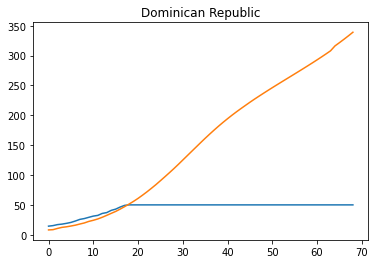

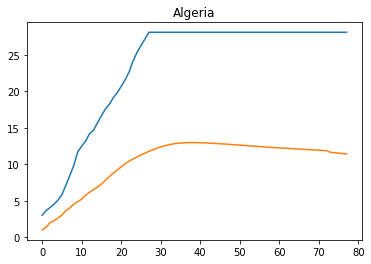

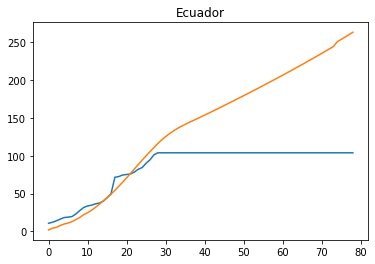

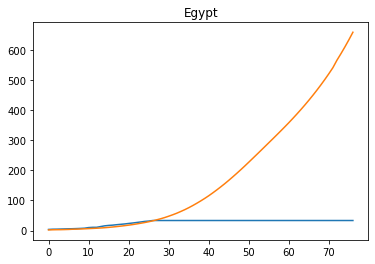

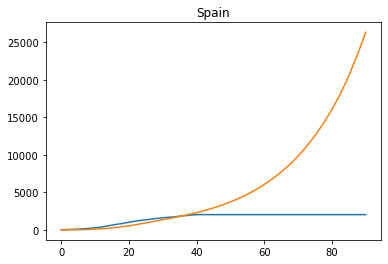

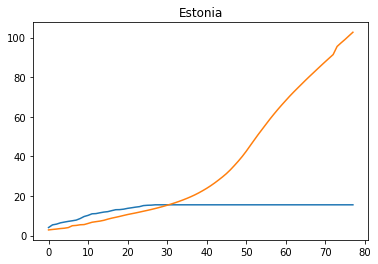

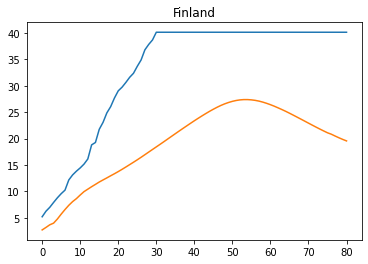

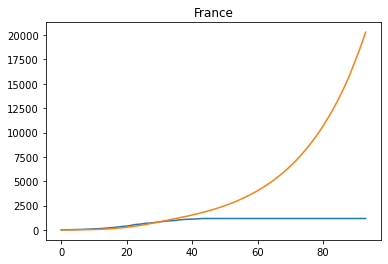

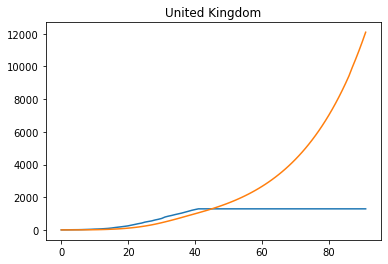

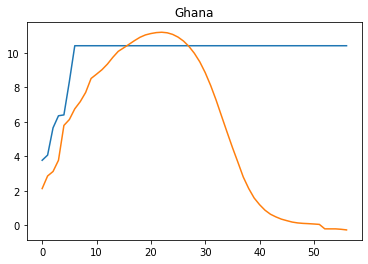

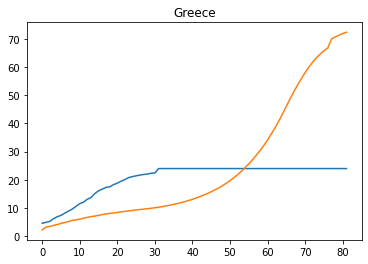

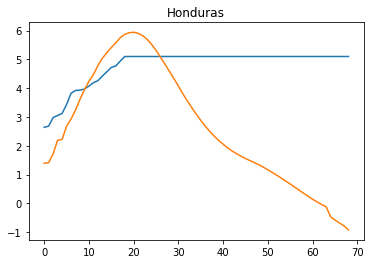

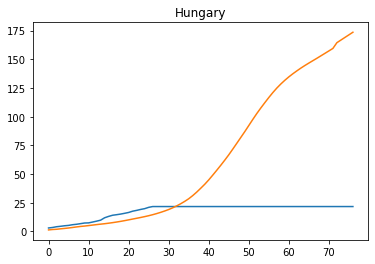

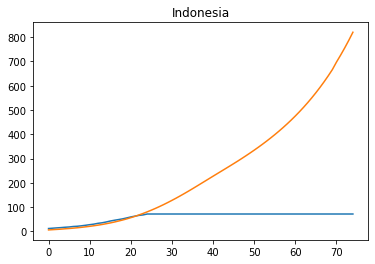

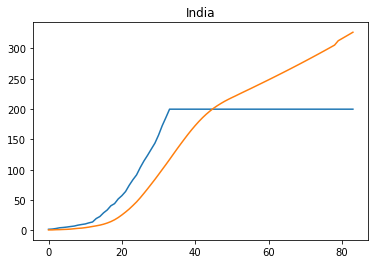

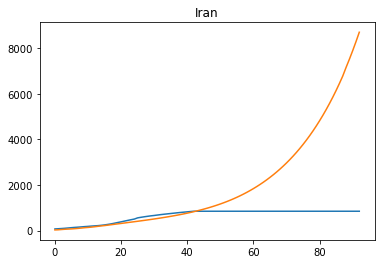

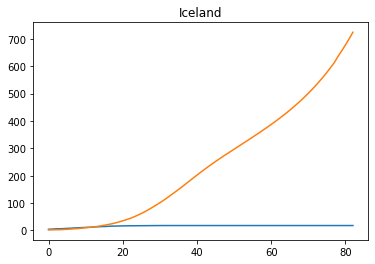

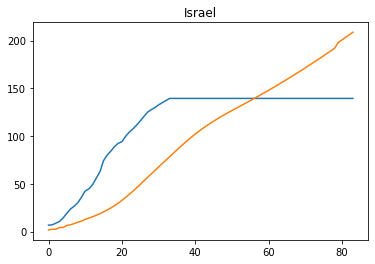

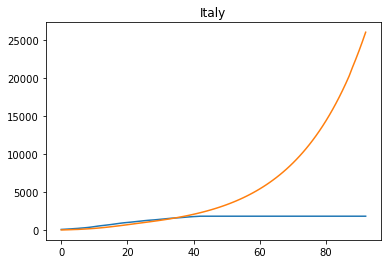

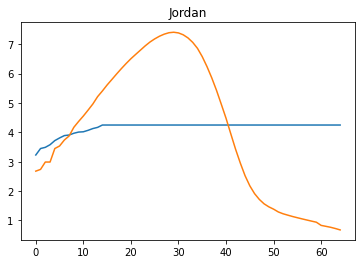

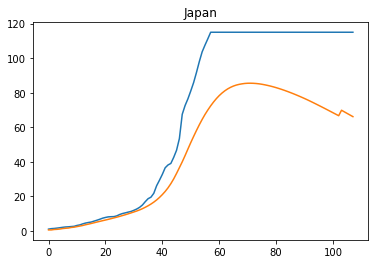

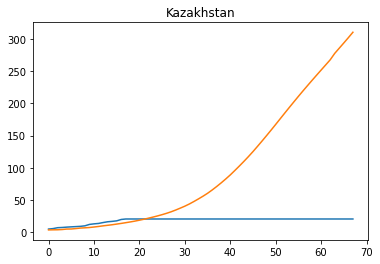

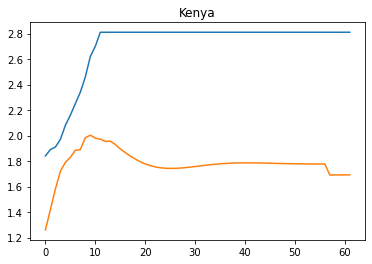

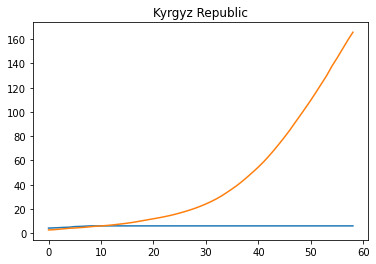

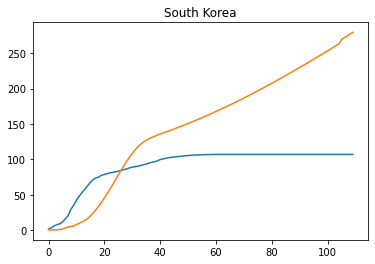

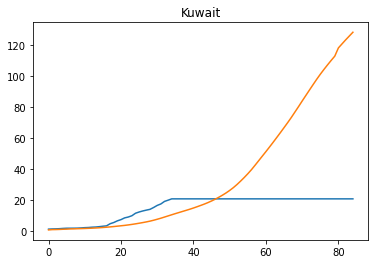

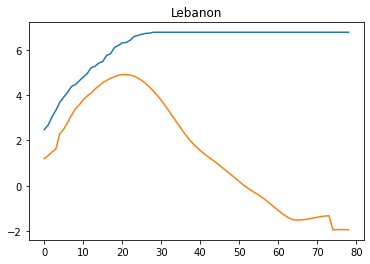

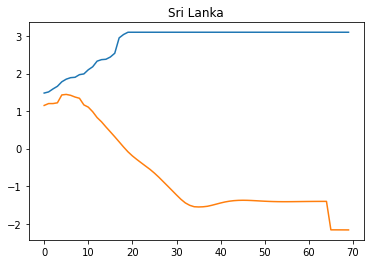

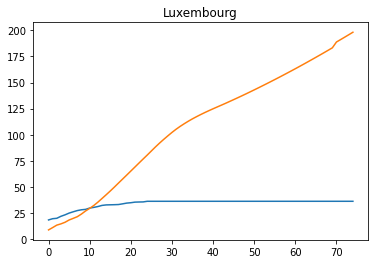

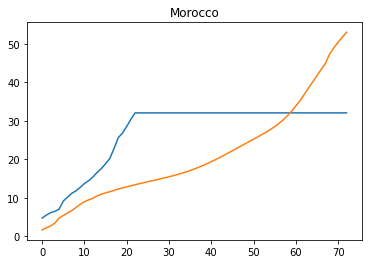

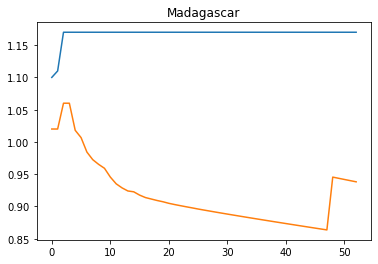

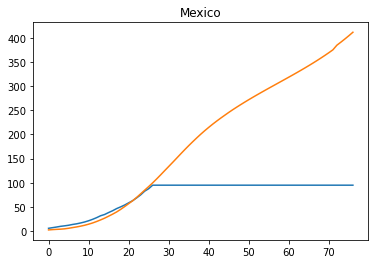

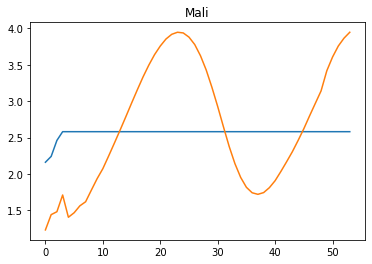

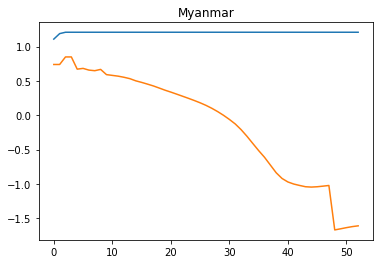

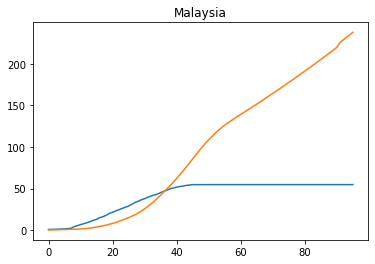

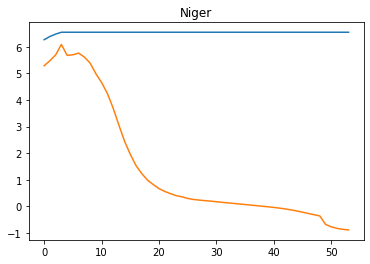

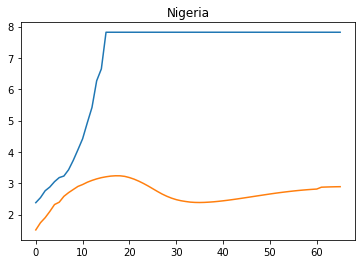

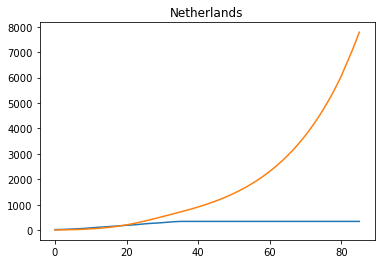

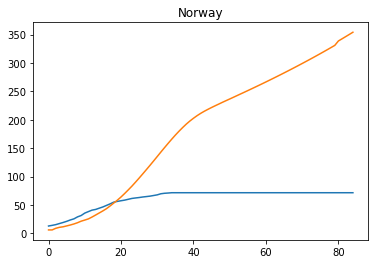

KeyboardInterrupt: 

In [8]:
# %debug
# from IPython.core.debugger import set_trace

prediction = 50

for country in train['CountryCode'].unique():
    country_data = train[train['CountryCode'] == country]
    if len(country_data.index) > 22:
        country_data = country_data.iloc[20:].copy()
        country_data = country_data.append(country_data.iloc[[-1]*prediction])
        support = country_data[x_cols].values
        support[9:, [5, 6, 7, 8, 9]] = 0
        for k in range(4, len(support) - 5):
            support[k, [5, 6, 7, 8, 9]] = np.array([support[np.array([-4, -3, -2, -1, 0]) + k + i, [5, 6, 7, 8, 9]].mean() for i in reversed(range(5))])
            support[k + 5 , [5, 6, 7, 8, 9]] = model.predict(support[k:k+1])
#             set_trace()


        plt.plot(country_data['ConfirmedCases'].values)
        plt.plot(support[:, 5])
        plt.title(country_data['CountryName'].iloc[0])
        plt.show()
    

In [ ]:
prediction = 50

for country in test['CountryCode'].unique():
    country_data = test[test['CountryCode'] == country]
    if len(country_data.index) > 22:
        country_data = country_data.iloc[20:].copy()
        country_data = country_data.append(country_data.iloc[[-1]*prediction])
        support = country_data[x_cols].values
        support[10:, [5, 6, 7, 8, 9]] = 0
        for k in range(4, len(support) - 5):
            support[k, [5, 6, 7, 8, 9]] = np.array([support[np.array([-4, -3, -2, -1, 0]) + k + i, [5, 6, 7, 8, 9]].mean() for i in reversed(range(5))])
            support[k + 5 , [5, 6, 7, 8, 9]] = model.predict(support[k:k+1])
#             set_trace()


        plt.plot(country_data['ConfirmedCases'].values)
        plt.plot(support[:, 5])
        plt.title(country_data['CountryName'].iloc[0])
        plt.show()

In [ ]:
for col in y_cols:
    print(col)
print()
for col in x_cols:
    print(col)

In [ ]:
trajectory = 
for k in range(50):
    new = model.predict(np.array(trajectory[-len(x):])[np.newaxis, :])
    trajectory.extend(list(new[0])[:-3])

plt.plot(data, 'k.')    
plt.plot(trajectory, 'b--')
plt.plot()

In [ ]:
# split = 1
# data = country_data.sort_values('Date')[['ConfirmedCases']].values[1:, 0] / 10000
# train_x, train_y, test_x, test_y = [], [], [], []
# piece_size = nbeats_args['forecast_horizon'] + nbeats_args['backcast_horizon']
# for k in range(int(len(data)) - piece_size):
#     current_piece = data[k:k + piece_size]
#     if k/len(data) < split:
#         train_x.append(current_piece[:nbeats_args['backcast_horizon']])
#         train_y.append(current_piece[nbeats_args['backcast_horizon']:])
#     else:
#         test_x.append(current_piece[:nbeats_args['backcast_horizon']])
#         test_y.append(current_piece[nbeats_args['backcast_horizon']:])
# train_x = np.array(train_x, dtype=np.float32) 
# train_y = np.array(train_y, dtype=np.float32) 
# test_x = np.array(test_x, dtype=np.float32) 
# test_y = np.array(test_y, dtype=np.float32) 
 
    
# train_x.shape, train_y.shape, test_x.shape, test_y.shape